In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, auc, roc_auc_score, cohen_kappa_score, log_loss, confusion_matrix
from collections import deque
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
from keras.layers import Dense, Activation, Input, Reshape, Embedding, concatenate, Dropout
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard, ReduceLROnPlateau
import keras
import tensorflow as tf
import random
import os
from collections import deque
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook, tqdm


/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
SIZE = 5000

df = pd.DataFrame()
np.random.seed(0)
df['Feature_0'] = np.random.uniform(0,100,SIZE) + np.random.rand(SIZE)
np.random.seed(1)
df['Feature_1'] = np.random.normal(0,100,SIZE) + np.random.rand(SIZE)
np.random.seed(2)
df['Feature_2'] = np.random.beta(1,10,SIZE)*10 + np.random.rand(SIZE)
np.random.seed(3)
df['Feature_3'] = np.random.beta(10,1,SIZE)*10 + np.random.rand(SIZE)
np.random.seed(4)
df['Feature_4'] = np.random.poisson(1,SIZE)*10 + np.random.rand(SIZE)

sc = MinMaxScaler()
df = pd.DataFrame(sc.fit_transform(df), columns=['Feature_0','Feature_1','Feature_2','Feature_3','Feature_4'])

np.random.seed(5)
df['Cat_0'] = np.random.randint(0,2,SIZE)
np.random.seed(6)
df['Cat_1'] = np.random.randint(0,2,SIZE)
np.random.seed(7)
df['Cat_2'] = np.random.randint(0,2,SIZE)
np.random.seed(8)
df['Cat_3'] = np.random.randint(0,2,SIZE)
np.random.seed(9)
df['Cat_4'] = np.random.randint(0,2,SIZE)

df['Treatment'] = 0
a = np.square(df['Feature_0'])*df['Cat_0'] + np.log(df['Feature_1']+1)*df['Cat_1'] + np.sqrt(df['Feature_2'])*df['Cat_2'] + (1/(1+np.exp(-df['Feature_3'])))*df['Cat_3'] + df['Feature_4']*df['Cat_4']

proportion = [8,33,56,80]

df.loc[a>np.percentile(a, proportion)[3], 'Treatment'] = 4
df.loc[(a<=np.percentile(a, proportion)[3]) & (a>np.percentile(a, proportion)[2]), 'Treatment'] = 3
df.loc[(a<=np.percentile(a, proportion)[2]) & (a>np.percentile(a, proportion)[1]), 'Treatment'] = 2
df.loc[(a<=np.percentile(a, proportion)[1]) & (a>np.percentile(a, proportion)[0]), 'Treatment'] = 1

np.random.seed(10)
b = 0.9*np.log(df['Feature_0'])*(df['Cat_0']+df['Cat_1']) + 0.8*np.log(df['Feature_1'])*(df['Cat_2']) + (-1*np.log(df['Feature_3']))*(df['Cat_3']) + (0.5/(1+np.exp(-df['Feature_2'])))*df['Cat_4'] + 0.4*df['Feature_4']*df['Treatment'] + 1.5*np.random.rand(SIZE)
b = 1/(1+np.exp(-b))
df['Outcome'] = (b>0.5).astype(int)

feature_cols = ['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Cat_0', 'Cat_1', 'Cat_2', 'Cat_3', 'Cat_4']

df.to_csv('synthetic_data.csv', index=False)
df.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Cat_0,Cat_1,Cat_2,Cat_3,Cat_4,Treatment,Outcome
0,0.547385,0.676824,0.160835,0.870523,0.662477,1,0,1,1,0,3,1
1,0.712239,0.366255,0.176376,0.658022,0.014532,0,1,0,0,0,1,0
2,0.598097,0.377505,0.180714,0.907436,0.176371,1,1,1,1,0,4,0
3,0.543332,0.302003,0.128728,0.867209,0.011746,1,0,0,1,1,2,1
4,0.421514,0.571057,0.096272,0.738091,0.173162,0,0,1,1,0,2,1


In [3]:
def random_everything(seed=42):
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)

def reset_keras():
    #K = reset_graph_with_backend
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    
class DQN(object):
    def __init__(self, gamma=1., n_actions=5, epsilon=1.0, input_dims=10,
                 lr=1e-3, bootstrap_size=64, 
                 fc1_dims=64, fc2_dims=64,
                 epsilon_dec=0.996, epsilon_min=0.01,
                 maxlen=5000, model_file='DQN_uplift.h5'):

        self.input_dims = input_dims
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.bootstrap_size = bootstrap_size   # bootstrap sampling from memory
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.maxlen = maxlen
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.state_memory = deque(maxlen=maxlen)
        self.action_memory = deque(maxlen=maxlen)
        self.reward_memory = deque(maxlen=maxlen)
        self.new_state_memory = deque(maxlen=maxlen)
        
        self.model, self.predict = self.build_dqn_network()
        self.model_file = model_file
        self.update_model()
    
    def build_dqn_network(self):
        
        random_everything(seed=42)
        num_input = Input(shape=(self.input_dims,))        
        dense1 = Dense(self.fc1_dims, activation='relu')(num_input)
        dense2 = Dense(self.fc2_dims, activation='relu')(dense1)
        output = Dense(self.n_actions, activation='linear')(dense2)    ## output 5 dimensions!
        
        model = Model(input=[num_input], output=[output])
        model.compile(optimizer=Adam(lr=self.lr), loss='mse')
        predict = Model(input=[num_input], output=[output])
        return model, predict
        
    def update_model(self):
        self.predict.set_weights(self.model.get_weights())
    
    def store_transition(self, state, action, reward, new_state):
        self.action_memory.append(action)
        self.state_memory.append(state)
        self.reward_memory.append(reward)
        self.new_state_memory.append(new_state)
    
    def choose_action(self, state, seed=42):
        state = state[np.newaxis,:]
        np.random.seed(seed)
        rand = np.random.random()
        if rand < self.epsilon:
            np.random.seed(seed)
            action = np.random.choice(self.action_space)
        else:
            actions = self.predict.predict(state)
            action = np.argmax(actions)
        return action
    
    def sample_buffer(self, bootstrap_size, seed=42): 
        
        # bootstrap sampling from memory
        np.random.seed(seed)
        batch = np.random.choice(len(self.state_memory), bootstrap_size)
        
        states = np.array(self.state_memory)[batch]
        new_states = np.array(self.new_state_memory)[batch]
        rewards = np.array(self.reward_memory)[batch]
        actions = np.array(self.action_memory)[batch]

        return states, actions, rewards, new_states, #dones
    
    def learn(self, seed=42):
        if len(self.action_memory) < self.maxlen:
            return
        state, action, reward, new_state = self.sample_buffer(self.bootstrap_size, seed=seed)
        
        action_values = np.array(self.action_space, dtype=np.int8)
        action_indices = action
        
        q_curr = self.predict.predict(state)
        q_next = self.predict.predict(new_state)
    
        q_target = q_curr.copy()

        ## action_indices are 1-D vector of the actions that the agent took during the sampled memory
        ## reward are the corresponding rewards for these action_indices
        ## We only need to update the Q table where the agent took actions and received rewards
        batch_idx = np.arange(self.bootstrap_size, dtype=np.int32)
        q_target[batch_idx, action_indices] = reward + self.gamma*np.max(q_next, axis=1)
        
        random_everything(seed=seed)
        _ = self.model.fit(state, q_target, verbose=0, )
        self.update_model()
        
        # epsilon decay
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min

    
    def save_model(self):
        self.model.save(self.model_file)
    
    def load_model(self):
        self.model.load_weights(self.model_file)
        self.predict.load_weights(self.model_file)
    

In [4]:
def get_reward(df, idx, policy_action):
        
    true_action = df.loc[idx, 'Treatment']
    target = df.loc[idx,'Outcome']
    
    if policy_action == true_action:
        return (target)
      
    elif true_action == 0 and policy_action > 0:
        return -(target)
    else:
        return 0
    

In [5]:
indices = np.arange(len(df.iloc[:,:]))
zero_reward_list = []
zero_Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 0
    state = state[np.newaxis,:]
    zero_reward = get_reward(df, idx, action)
    zero_reward_list.append(zero_reward)
    
indices = np.arange(len(df.iloc[:,:]))
one_reward_list = []
one_Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 1
    state = state[np.newaxis,:]
    one_reward = get_reward(df, idx, action)
    one_reward_list.append(one_reward)

indices = np.arange(len(df.iloc[:,:]))
two_reward_list = []
two_Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 2
    state = state[np.newaxis,:]
    two_reward = get_reward(df, idx, action)
    two_reward_list.append(two_reward)
    
indices = np.arange(len(df.iloc[:,:]))
three_reward_list = []
three_Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 3
    state = state[np.newaxis,:]
    three_reward = get_reward(df, idx, action)
    three_reward_list.append(three_reward)
    
indices = np.arange(len(df.iloc[:,:]))
four_reward_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 4
    state = state[np.newaxis,:]
    four_reward = get_reward(df, idx, action)
    four_reward_list.append(four_reward)

indices = np.arange(len(df.iloc[:,:]))
random_reward_list = []
agent = DQN(epsilon=1.0)
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = agent.choose_action(state, seed=idx)
    state = state[np.newaxis,:]
    random_reward = get_reward(df, idx, action)
    random_reward_list.append(random_reward)

print(np.mean(zero_reward_list))
print(np.mean(one_reward_list))
print(np.mean(two_reward_list))
print(np.mean(three_reward_list))
print(np.mean(four_reward_list))
print(np.mean(random_reward_list))


0.0624
0.0656
0.0628
0.0684
0.0646
0.0736


In [6]:
reset_keras()

feature_cols = ['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Cat_0', 'Cat_1', 'Cat_2', 'Cat_3', 'Cat_4']

NUM_EPISODES = 600
reward_history = []

n_sample = 5000

random_everything(seed=42)


agent = DQN(lr=1e-3, fc1_dims=128, fc2_dims=128, bootstrap_size=5000, 
            maxlen=n_sample, epsilon_dec=0.996)

best_mean_reward = 0.
mean_reward_history = []

for e in tqdm_notebook(range(NUM_EPISODES)):
    reward_history.append([])
    indices = np.arange(len(df.iloc[:,:]))
    
    random_everything(seed=e%5)
    np.random.shuffle(indices)
    
    idx = indices[0]
    state = df.loc[idx,feature_cols].values
    
    for idx in indices[1:n_sample]:
        #state = df.loc[idx,feature_cols].values
        action = agent.choose_action(state, seed=idx)
        reward = get_reward(df, idx, action)
        reward_history[e].append(reward)
        new_state = df.loc[idx,feature_cols].values
        agent.store_transition(state, action, reward, new_state)
        state = new_state
        
    agent.learn(seed=idx)
    mean_reward = np.mean(reward_history[e])
    
    if e%100 == 0:
        print(f'episode {e} mean_reward {mean_reward:.4}')
    state_memory = np.array(agent.state_memory)
    action_memory = np.array(agent.action_memory)
    reward_memory = np.array(agent.reward_memory)

    actions = np.zeros([len(action_memory), agent.n_actions])
    actions[np.arange(len(action_memory)), action_memory] = 1
        
    mean_reward_history.append(mean_reward)
    if mean_reward > best_mean_reward:
        agent.save_model()
        best_mean_reward = mean_reward
   

episode 0 mean_reward 0.07361
episode 100 mean_reward 0.08022
episode 200 mean_reward 0.07622
episode 300 mean_reward 0.07902
episode 400 mean_reward 0.08022
episode 500 mean_reward 0.07241



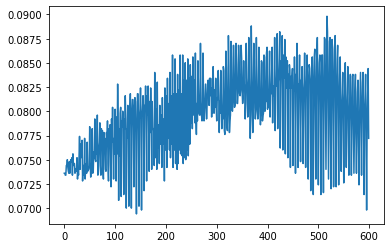

In [7]:
plt.plot(np.arange(len(mean_reward_history)), mean_reward_history)

In [8]:
#agent = DQN(epsilon=0., lr=1e-3, fc1_dims=128, fc2_dims=128, bootstrap_sizebatch_size=5000, maxlen=n_sample)

agent.load_model()
indices = np.arange(len(df.iloc[:,:]))
agent.load_model()
action_list = []
reward_list = []
Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = agent.choose_action(state, seed=idx)
    state = state[np.newaxis,:]
    Q = agent.predict.predict(state)[0]
    reward = get_reward(df, idx, action)
    action_list.append(action)
    reward_list.append(reward)
    Q_list.append(Q)

print(np.mean(reward_list))
print(np.unique(action_list, return_counts=True))

0.1092
(array([0, 1, 2, 3, 4]), array([1024,  814,  319, 2103,  740]))


Text(0.5, 1.0, 'Cumulative uplift response unweighted reward comparison')

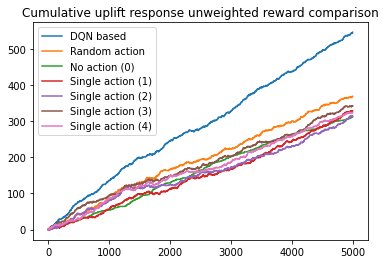

In [9]:
plt.plot(range(len(reward_list)), np.cumsum(reward_list), label='DQN based')
plt.plot(range(len(reward_list)), np.cumsum(random_reward_list), label='Random action')
plt.plot(range(len(reward_list)), np.cumsum(zero_reward_list), label='No action (0)')
plt.plot(range(len(reward_list)), np.cumsum(one_reward_list), label='Single action (1)')
plt.plot(range(len(reward_list)), np.cumsum(two_reward_list), label='Single action (2)')
plt.plot(range(len(reward_list)), np.cumsum(three_reward_list), label='Single action (3)')
plt.plot(range(len(reward_list)), np.cumsum(four_reward_list), label='Single action (4)')

plt.xlabel='Number of states'
plt.ylabel='Cumulative reward'
plt.legend()
plt.title('Cumulative uplift response unweighted reward comparison')

In [10]:
res = pd.concat([df, pd.DataFrame(np.concatenate([np.array(action_list)[:,np.newaxis].astype(int), np.array(Q_list)],1), 
                                  columns=['Action','Q_0','Q_1','Q_2','Q_3','Q_4'])
                ],1)
res.loc[res['Outcome']==1,['Treatment','Action','Q_0','Q_1','Q_2','Q_3','Q_4']]


,Treatment,Action,Q_0,Q_1,Q_2,Q_3,Q_4
0,3,0.0,29.417860,28.392311,16.676619,25.928364,28.573601
3,2,3.0,28.869581,26.952620,28.882784,29.373989,27.730629
4,2,4.0,23.278017,28.320269,28.140791,27.008999,29.148813
7,4,4.0,21.614647,25.586216,27.439344,29.561579,28.907537
8,0,0.0,29.993252,26.974684,27.497894,28.523331,20.325167
...,...,...,...,...,...,...,...
4986,2,0.0,28.886499,27.134918,11.413032,28.676193,22.865829
4987,1,3.0,28.019995,24.389233,26.959618,31.075068,27.645594
4994,3,3.0,24.686941,20.797934,26.564905,29.451679,25.513983
4998,0,0.0,29.960464,26.713476,27.963163,27.205002,28.528419


In [12]:
agent.predict.predict(state)

array([[28.81729 , 26.91325 , 28.062002, 29.341381, 23.072374]],
      dtype=float32)

In [13]:
state

array([[0.95955637, 0.76233371, 0.0584064 , 0.73094635, 0.01638532,
        1.        , 0.        , 1.        , 0.        , 0.        ]])